In [1]:
%cd /home/josh/PycharmProjects/Muon_magnets

/home/josh/PycharmProjects/Muon_magnets


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

import modules.functions as func
from modules.muon import Muon
from modules.ensemble import Ensemble

from modules.dipole import Dipole
from modules.island import Island
from modules.grid import Grid
#from modules.field_grid import make_field
from modules.multi_process import MP_fields
from modules.model_equations import static_GKT

%matplotlib inline

#### Used to create grid of points to calculte field at
In the final code the field will instead be calcualted for each muon using the muons x,y,z position

In [9]:
def setup_field(width, height, nx, ny):
    """
    :param tuple max_loc: (X, Y) of furthest dipole
    :param float edge_buffer: Distance around edge of grid to calculate field for
    :param int nx: Number of field x points
    :param int ny: Number of field y points
    :rtype: dict
    :return: Dictionary containing coordinates for a field over the dipole array
    """
    edge_buffer_x = width/10
    edge_buffer_y = height/10
    # Determine region to calculate field lines/plot over
    field_region = [[(-width/2) - edge_buffer_x, (width/2) + edge_buffer_x],
                    [(-height/2) - edge_buffer_y, (height/2) + edge_buffer_y]]
    field_locations = {"x_vals": np.linspace(*field_region[0], nx),
                       "y_vals": np.linspace(*field_region[1], ny)}
    return field_locations

In [28]:
def calculate_field(xlocs, ylocs, grid):
    
    x_len, y_len = len(x_locs), len(y_locs)
    Ex = np.zeros([x_len, y_len])
    Ey = np.zeros([x_len, y_len])
    percent = int(x_len/20)
    for i, x in enumerate(x_locs):
        if i % percent == 0:
            print(f"{i*100/x_len}%")
        for j, y in enumerate(y_locs):
            for isle in grid.islands:
                ex, ey, _ = isle.get_mag_field([x, y, 10e-6])
                Ex[j][i] += ex
                Ey[j][i] += ey
    print("Finished field calculation")
    return Ex, Ey

In [63]:
# Create a small grid
# N
isle_1 = Island(orientation=0, location=[0, 10e-6, 0], strength=2e-8, size=[1.6e-6, 700e-9])

# E
isle_2 = Island(orientation=-90, location=[10e-6, 0, 0], strength=2e-8, size=[1.6e-6, 700e-9])

# S
isle_3 = Island(orientation=180, location=[0, -10e-6, 0], strength=2e-8, size=[1.6e-6, 700e-9])

# W
isle_4 = Island(orientation=90, location=[-10e-6, 0, 0], strength=2e-8, size=[1.6e-6, 700e-9])
grid = Grid.__new__(Grid)
grid.islands = [isle_1, isle_2, isle_3, isle_4]
grid.locations = np.array([isle.location for isle in grid.islands])

In [64]:
x_range = max(grid.locations[:,0]) - min(grid.locations[:,0])
y_range = max(grid.locations[:,1]) - min(grid.locations[:,1])
field_locations = setup_field(x_range, y_range, 250, 250)
x_locs = field_locations["x_vals"]
y_locs = field_locations["y_vals"]

## Calculate resultant field over the whole grid

In [65]:
Ex, Ey = calculate_field(x_locs, y_locs, grid)

0.0%
4.8%
9.6%
14.4%
19.2%
24.0%
28.8%
33.6%
38.4%
43.2%
48.0%
52.8%
57.6%
62.4%
67.2%
72.0%
76.8%
81.6%
86.4%
91.2%
96.0%


## Plotting

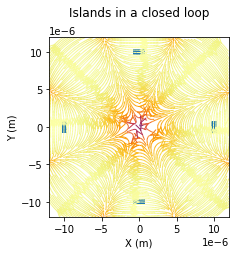

In [66]:
color = 2 * np.log(np.hypot(Ex, Ey))

fig, ax = plt.subplots(figsize=func.set_fig_size(width="muon_paper"))
ax.streamplot(x_locs, y_locs, Ex, Ey,
              color=color,
              linewidth=1,
              cmap=plt.cm.inferno,
              density=4,
              arrowstyle='->',
              arrowsize=1.5)
grid.make_collection()
ax.add_collection(grid.collection)

# Format graph
ax.set_xlim(min(x_locs), max(x_locs))
ax.set_ylim(min(y_locs), max(y_locs))
ax.ticklabel_format(axis="both", style="sci", scilimits=(-6, -6))
ax.set_aspect("equal")

# LABELS
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_title("Islands in a closed loop", y=1.08)

plt.tight_layout(pad=1)
plt.show()